<img src="./img/uomlogo.png" align="left"/><br><br>
# PHYS20762 - Project - Measuring The Drop Spreading Law

Jatin Sharma<br>
University of Manchester  
January 2021

We first initialise our Python interpreter


In [1]:
# Initialisation
import string
from math import *
import numpy as np
import matplotlib.pyplot as plt
import random

plt.rcParams.update({'font.size': 14})
plt.style.use('default')

In [2]:
# Constants 
DROP_VOLUME = 7.6 * 10 ** -15  # m^3
MICROMETERS_METERS_CONVERSION = 10 ** -6

In [3]:
# Functions 
def standard_deviation_error(data1, data2, data3):
    """
    Calculates the standard deviation error by combining 3 sets of data and the mean of the 3 data sets.

    Parameters
    ----------
    radius_data1 : numpy array 
    radius_data2 : numpy array
    radius_data3 : numpy array

    Returns
    -------
    radius_mean : numpy array
    radius_std : numpy array 

    """
    data = np.array([data1, data2, data3])
    mean = np.mean(data, axis=0)
    standard_deviation = np.std(data, axis=0)
    
    return mean, standard_deviation

def drop_height_calculator(radius_data):
    """
    Calculates the drop height using data for the radius.

    Parameters
    ----------
    radius_data : numpy array

    Returns
    -------
    drop_height : numpy aray
    """
    drop_height = []
    for line in range(len(radius_data[:])):
        roots = np.roots([1, 0, 3 * (radius_data[line] ** 2), (-6 * DROP_VOLUME) / np.pi])
        real_roots = roots[~np.iscomplex(roots)]
        drop_height = np.append(drop_height, real_roots) 
        
    return drop_height

def contact_angle_calculator(radius_data, height_data):
    """
    Calculates the contact angle using data for the drop radius and height.

    Parameters
    ----------
    radius_data : numpy array
    height_data : numpy array
    
    Returns
    -------
    contact_angle : numpy aray
    """
    contact_angle_array = []
    for line in range(len(radius_data[:])):
       contact_angle = (np.pi / 2) - np.arctan(((radius_data[line] ** 2) - (height_data[line] ** 2)) / 
                                               (2 * height_data[line] *  radius_data[line]))  
       contact_angle_array = np.append(contact_angle_array, contact_angle)
        
    return contact_angle_array

def contact_line_speed_calculator(radius_data, time_data):
    """
    Calculates the contact line speed given data for the drop radius and time.

    Parameters
    ----------
    radius_data : numpy array
    time_data : numpy array 

    Returns
    -------
    contact_line_speed_array: numpy aray
    """
    contact_line_speed_array = []
    for line in range(len(radius_data[:]) - 1):
        contact_line_speed = (radius_data[line + 1] - radius_data[line]) / (time_data[line + 1] - time_data[line])
        contact_line_speed_array = np.append(contact_line_speed_array, contact_line_speed)
        
    return contact_line_speed_array

def spreading_law_calculator(index_value):
    """
    Fits a spreading law to the contact line speed data and the contact angle 
    data, using a linear fit of the form m*x+c. Returns m and c with their 
    respective errors. Also calculates the expected error based on the fit.
    
    Parameters
    ----------
    index_value : int
        the number the equilibrum contact angle is raised to in the spreading law.

    Returns
    -------
    fit_m : float
    sigma_m : float
    fit_c : float
    sigma_c : float

    """
    fit_parameters, fit_errors = np.polyfit((CONTACT_ANGLE_MEAN[1:]) ** index_value, CONTACT_LINE_SPEED_MEAN * 
                                            MICROMETERS_METERS_CONVERSION, 1, cov=True)
    contact_line_speed_fit = np.polyval(fit_parameters, CONTACT_ANGLE_MEAN[1:] ** index_value)
    fit_m = fit_parameters[0]
    fit_c = fit_parameters[1]
    sigma_m = np.sqrt(fit_errors[0][0])
    sigma_c = np.sqrt(fit_errors[1][1])
    # Expected error on data from the assumed fit
    sigma_contact_line_speed_fit = np.sqrt(np.sum(np.power((CONTACT_LINE_SPEED_MEAN * MICROMETERS_METERS_CONVERSION)
                                                           - contact_line_speed_fit, 2)) / 
                                           (len(CONTACT_LINE_SPEED_MEAN) - 2))

    return fit_m, sigma_m, fit_c, sigma_c, contact_line_speed_fit, sigma_contact_line_speed_fit

def equilibrum_contact_angle_calculator(characteristic_speed, y_intercept, index):
    """
    Calculates the equilibrum contact angle for a given characteristic speed
    and y intercept value found from fitting the data to a spreading law.

    Parameters
    ----------
    characteristic_speed : float
    y_intercept : float

    Returns
    -------
    equilibrum_contact_angle : float

    """
    equilibrum_contact_angle = (-y_intercept / characteristic_speed) ** (1 / index)
    return equilibrum_contact_angle

def contact_angle_error_calculator(characteristic_speed, characteristic_speed_error, y_intercept, y_intercept_error, index):
    """
    Calculates the error on the equilibrum contact angle for different indexes using propogation formulae. 

    Parameters
    ----------
    characteristic_speed : float
    characteristic_speed_error : float
    y_intercept : float
    y_intercept_error : float

    Returns
    -------
    contact_angle_error : float

    """
    if index == 3:
        contact_angle_error = np.sqrt(((1 / (9 * characteristic_speed ** 2)) * ((-y_intercept / (characteristic_speed)) 
                                                                                ** -(4 / 3)) * y_intercept_error ** 2) + 
                                      (((y_intercept / (3 * characteristic_speed ** 2))) ** 2) * 
                                      ((-y_intercept / (characteristic_speed)) ** -(4 / 3)) * characteristic_speed_error ** 2)
    if index == 2: 
        contact_angle_error = np.sqrt(((1 / (4 * characteristic_speed ** 2)) * ((-y_intercept / (characteristic_speed)) 
                                                                                ** -(1)) * y_intercept_error ** 2) + 
                                      (((y_intercept / (2 * characteristic_speed ** 2))) ** 2) * 
                                      ((-y_intercept / (characteristic_speed)) ** -(1)) * characteristic_speed_error ** 2)
    return contact_angle_error

def chi_squared_calculator(data, fitted_data, uncertainty):
    """
    Returns chi squared and the reduced chi squared.

    Parameters
    ----------
    prediction : numpy array
    data : numpy array 
    uncertainty : numpy array 

    Returns
    -------
    chi_squared : float
    reduced_chisquared : float
    """
    chi_squared = np.sum(((data - fitted_data) / uncertainty) ** 2)
    # we have 2 fit parameters (linear fit)
    degrees_of_freedom = len(data) - 2 
    reduced_chisquared = chi_squared / degrees_of_freedom
    return chi_squared, reduced_chisquared

def non_linear_fit(index_value):
    """
    Fits a spreading law to the contact line speed data and the contact angle 
    data, using a non-linear fit. Returns the fitted constants with their 
    respective errors. Also calculates the expected error based on the fit.
    
    Parameters
    ----------
    index_value : int
        the number the equilibrum contact angle is raised to in the spreading law.

    Returns
    -------
    fit_m : float
    sigma_m : float
    fit_c : float
    sigma_c : float

    """
    if index_value == 2:
        fit_parameters, fit_errors = np.polyfit((CONTACT_ANGLE_MEAN[1:]), CONTACT_LINE_SPEED_MEAN * 
                                                MICROMETERS_METERS_CONVERSION, index_value, cov=True)
        fit_u0 = fit_parameters[0]
        fit_b = fit_parameters[1]
        fit_a = fit_parameters[2]
        sigma_u0 = np.sqrt(fit_errors[0][0])
        sigma_b = np.sqrt(fit_errors[1][1])
        sigma_a = np.sqrt(fit_errors[2][2])
        # Expected error on data from the assumed fit

        return fit_u0, fit_b, fit_a
    
    if index_value == 3:
        fit_parameters, fit_errors = np.polyfit((CONTACT_ANGLE_MEAN[1:]), CONTACT_LINE_SPEED_MEAN * 
                                                MICROMETERS_METERS_CONVERSION, index_value, cov=True)
        fit_u0 = fit_parameters[0]
        fit_c = fit_parameters[1]
        fit_b = fit_parameters[2]
        fit_a = fit_parameters[3]
        sigma_u0 = np.sqrt(fit_errors[0][0])
        sigma_c = np.sqrt(fit_errors[1][1])
        sigma_b = np.sqrt(fit_errors[2][2])
        sigma_a = np.sqrt(fit_errors[3][3])
        
        return fit_u0, fit_c, fit_b, fit_a


![](./img/bee.png)
## Experimental Data

This is data that you are working with. It consists of a sequence of circle radii ($R$, measured in micrometers), obtained from image processing in three different experimental runs. The corresponding time ($t$, measured in seconds) was obtained from the image timestamps measured from the beginning of the experiment.     

In [4]:
# Radius data 
# experiment 1
RADIUS_DATA_1 = np.array([59.513027, 66.368389, 69.506166, 71.700852, 74.735925, 76.007795, 76.695256, 78.039551, 79.598386, 80.075493, 80.079624, 81.495363, 82.598934, 83.172805, 84.919440, 85.155809, 85.718415, 85.920147, 86.000243, 87.120934, 87.507943, 87.786892, 87.060409, 88.086562, 88.113767, 88.436448, 89.082172, 89.139957, 89.210538, 89.356928, 90.312937, 90.406557, 90.754907, 90.88941, 91.096467])
# experiment 2
RADIUS_DATA_2 = np.array([59.810888, 65.360919, 69.088934, 72.594631, 74.694093, 76.440186, 78.133942, 78.618537, 79.753566, 80.745559, 81.422723, 81.634563, 82.861597, 84.335873, 85.362055, 85.537714, 86.159399, 86.873675, 86.918131, 87.003533, 87.126402, 87.155440, 87.224911, 87.394479, 87.433936, 87.626938, 87.701465, 87.834029, 87.963874, 88.153147, 88.209880, 88.542036, 88.86527, 89.082038, 89.214132])
# experiment 3
RADIUS_DATA_3 = np.array([58.200029, 64.826353, 69.332991, 73.504694, 74.295033, 77.506575, 78.413291, 79.952682, 81.339708, 81.938359, 82.528196, 82.807452, 83.378999, 84.521468, 84.507216, 85.064265, 85.247146, 85.900079, 86.475709, 86.776052, 87.158810, 87.343755, 87.448085, 87.822712, 88.140434, 88.311032, 88.619312, 88.970210, 89.373613, 89.754486, 89.900430, 90.116608, 90.288358, 90.711677, 90.989783])
# time
TIME = np.array([0.500000, 1.000000, 1.500000, 2.000000, 2.500000, 3.000000, 3.500000, 4.000000, 4.500000, 5.000000, 5.500000, 6.000000, 6.500000, 7.000000, 7.500000, 8.000000, 8.500000, 9.000000, 9.500000, 10.000000, 10.500000, 11.000000, 11.500000, 12.000000, 12.500000, 13.000000, 13.500000, 14.000000, 14.500000, 15.000000, 15.500000, 16.000000, 16.500000, 17.000000, 17.500000])

Let's plot this data to see what it looks like:

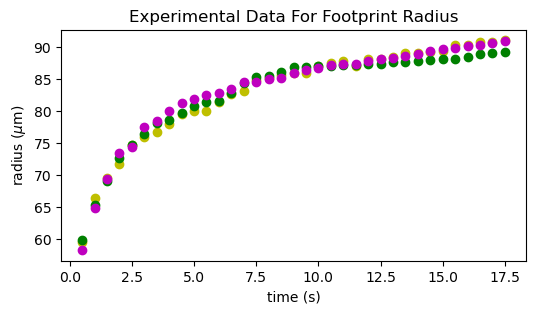

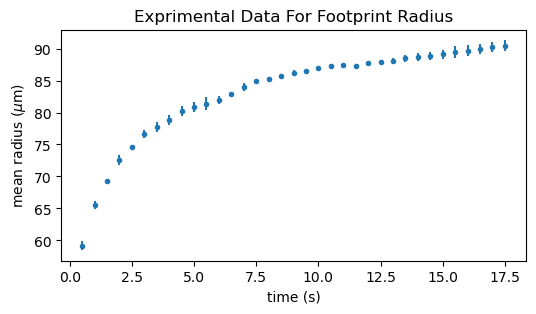

In [5]:
# tweeking the figure size
plt.rcParams["figure.figsize"] = (6,3)
plt.figure()
# plotting data from experimental runs 1-3:
plt.plot(TIME, RADIUS_DATA_1, "yo")
plt.plot(TIME, RADIUS_DATA_2, "go")
plt.plot(TIME, RADIUS_DATA_3, "mo")
# setting axis labels & figures 
plt.xlabel("time (s)")
plt.ylabel("radius ($\mu$m)")
plt.title("Experimental Data For Footprint Radius")
# displaying the plot
plt.show()
# finding the mean radius values along with their associated standard deviation (error).
RADIUS_MEAN, RADIUS_STD = standard_deviation_error(RADIUS_DATA_1, RADIUS_DATA_2,
                                                   RADIUS_DATA_3)
# plotting the mean radius against time along with their associated error bars.
# the error in the time is taken to be zero as it is know accurately.
plt.rcParams["figure.figsize"] = (6,3)
plt.figure()
plt.errorbar(TIME, RADIUS_MEAN, yerr=RADIUS_STD, fmt='.')
plt.xlabel('time (s)')
plt.ylabel('mean radius ($\mu$m)')
plt.title('Exprimental Data For Footprint Radius')
plt.show()



![](./img/bee.png)
## Extracting Quantities Using Experimental Data

In order to find the spreading law: a relationship between the speed of the contact line ($U$) and the contact angle ($\theta$), we need to first find the quantities themselves, ie express $U$ and $\theta$ using $R=R(t)$. 

The speed of the contact line can be calculated using $U = \frac{dR}{dt} \approx \frac{R(t+\delta t)-R(t)}{\delta t}$, where $R(t+\delta t)$ and $R(t)$ are two sequential values of the footprint radii measured with time intreval $\delta t$ apart.  

To find the contact angle, we make the spherical cap approximation that allows us to calculate the height of the drop ($H$) from its volume ($V=7.6$ pL) and its footprint radius ($R$) which are known from experiments via relationship $V=\frac{\pi}{6}H(3R^2+H^2)$. The contact angle can then be found from $R$ and $H$ using $\theta = \frac{\pi}{2} - \mathrm{atan}\frac{R^2-H^2}{2HR}$. 

There are three sets of experimental data, so for each one of them a relationship $U=U(\theta)$ should be found.

In [6]:
# convert our radius measurements into metres from micrometres
RADIUS_DATA_1_METRES = RADIUS_DATA_1 * MICROMETERS_METERS_CONVERSION
RADIUS_DATA_2_METRES = RADIUS_DATA_2 * MICROMETERS_METERS_CONVERSION
RADIUS_DATA_3_METRES = RADIUS_DATA_3 * MICROMETERS_METERS_CONVERSION
# find the speed of the contact line in micrometers per second
CONTACT_LINE_SPEED_DATA_1 = contact_line_speed_calculator(RADIUS_DATA_1, TIME)
CONTACT_LINE_SPEED_DATA_2 = contact_line_speed_calculator(RADIUS_DATA_2, TIME)
CONTACT_LINE_SPEED_DATA_3 = contact_line_speed_calculator(RADIUS_DATA_3, TIME)
# find the height of the drop in meters
DROP_HEIGHT_DATA_1 = drop_height_calculator(RADIUS_DATA_1_METRES)
DROP_HEIGHT_DATA_2 = drop_height_calculator(RADIUS_DATA_2_METRES)
DROP_HEIGHT_DATA_3 = drop_height_calculator(RADIUS_DATA_3_METRES)
# find the contact angle
CONTACT_ANGLE_DATA_1 = contact_angle_calculator(RADIUS_DATA_1_METRES, DROP_HEIGHT_DATA_1)
CONTACT_ANGLE_DATA_2 = contact_angle_calculator(RADIUS_DATA_2_METRES, DROP_HEIGHT_DATA_2)
CONTACT_ANGLE_DATA_3 = contact_angle_calculator(RADIUS_DATA_3_METRES, DROP_HEIGHT_DATA_3)

Let's plot these results to see what they look like:

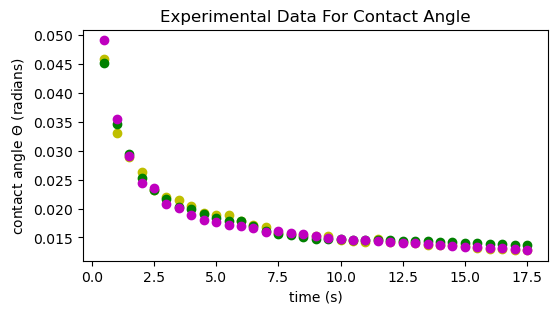

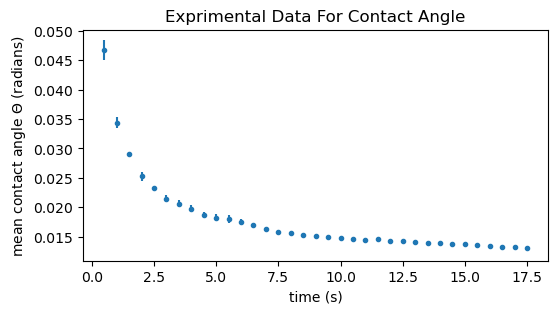

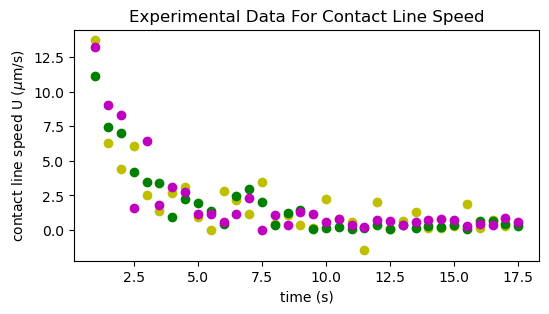

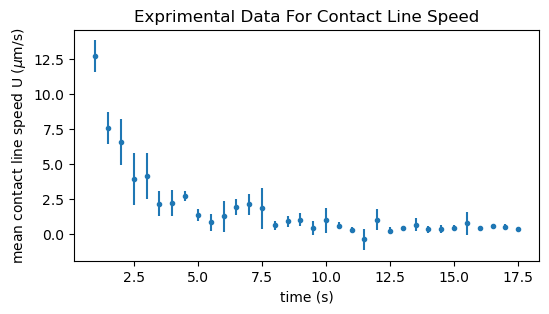

In [7]:
# plot the contact angle against time 
# tweeking the figure size
plt.rcParams["figure.figsize"] = (6,3)
plt.figure()
# plotting data from experimental runs 1-3:
plt.plot(TIME, CONTACT_ANGLE_DATA_1.real, "yo")
plt.plot(TIME, CONTACT_ANGLE_DATA_2.real, "go")
plt.plot(TIME, CONTACT_ANGLE_DATA_3.real, "mo")
# setting axis labels & figures 
plt.xlabel("time (s)")
plt.ylabel("contact angle $\Theta$ (radians)")
plt.title("Experimental Data For Contact Angle")
# displaying the plot
plt.show()
# finding the mean contact angle values along with their associated standard deviation (error)
CONTACT_ANGLE_MEAN, CONTACT_ANGLE_STD = standard_deviation_error(CONTACT_ANGLE_DATA_1.real, CONTACT_ANGLE_DATA_2.real,
                                                   CONTACT_ANGLE_DATA_3.real)
# plotting the mean contact angle against time along with their associated error bars
plt.rcParams["figure.figsize"] = (6,3)
plt.figure()
plt.errorbar(TIME, CONTACT_ANGLE_MEAN, yerr=CONTACT_ANGLE_STD, fmt='.')
plt.xlabel('time (s)')
plt.ylabel('mean contact angle $\Theta$ (radians)')
plt.title('Exprimental Data For Contact Angle')
plt.show()
# plot the contact line speed against time
# tweeking the figure size
plt.rcParams["figure.figsize"] = (6,3)
plt.figure()
# plotting data from experimental runs 1-3:
# the first data point in the time array is not plotted as the contact line speed array is one data point fewer
plt.plot(TIME[1:], CONTACT_LINE_SPEED_DATA_1, "yo")
plt.plot(TIME[1:], CONTACT_LINE_SPEED_DATA_2, "go")
plt.plot(TIME[1:], CONTACT_LINE_SPEED_DATA_3, "mo")
# setting axis labels & figures 
plt.xlabel("time (s)")
plt.ylabel("contact line speed U ($\mu$m/s)")
plt.title("Experimental Data For Contact Line Speed")
# displaying the plot
plt.show()
# finding the mean contact line speed values along with their associated standard deviation (error)
CONTACT_LINE_SPEED_MEAN, CONTACT_LINE_SPEED_STD = standard_deviation_error(CONTACT_LINE_SPEED_DATA_1, CONTACT_LINE_SPEED_DATA_2,
                                                   CONTACT_LINE_SPEED_DATA_3)
# plotting the mean contact line speed against time along with their associated error bars
plt.rcParams["figure.figsize"] = (6,3)
plt.figure()
plt.errorbar(TIME[1:], CONTACT_LINE_SPEED_MEAN, yerr=CONTACT_LINE_SPEED_STD, fmt='.')
plt.xlabel('time (s)')
plt.ylabel('mean contact line speed U ($\mu$m/s)')
plt.title('Exprimental Data For Contact Line Speed')
plt.show()

The data $U=U(\theta)$ obtained for each of the three experimental runs is used to estimate the relationship between the mean contact line speed and the mean contact angle, and the corresponding errors on those. The result of this is plotted below. 

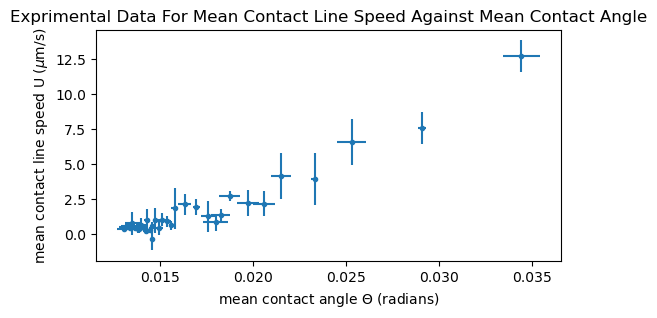

In [8]:
# plotting the mean contact line speed against the mean surface angle along with their associated error bars
plt.rcParams["figure.figsize"] = (6,3)
plt.figure()
# the first data point in the contact angle mean array is removed as the contact line speed array has one data point fewer
plt.errorbar(CONTACT_ANGLE_MEAN[1:], CONTACT_LINE_SPEED_MEAN, yerr=CONTACT_LINE_SPEED_STD, xerr=CONTACT_ANGLE_STD[1:], fmt='.')
plt.xlabel('mean contact angle $\Theta$ (radians)')
plt.ylabel('mean contact line speed U ($\mu$m/s)')
plt.title('Exprimental Data For Mean Contact Line Speed Against Mean Contact Angle')
plt.show()

![](./img/bee.png)
## Fitting Spreading Laws

We will now attemp to fit the Cox-Voinov law ($U = U_0( \theta^3 –  \theta_0^3)$) and the de Gennes law ($U = U_0( \theta^2 –  \theta_0^2)$) to the mean data $U=U(\theta)$ ploted above, where $U_0$ is termed the characteristic speed of the contact line, and $\theta_0$ is the equilibrium contact angle (when $\theta=\theta_0$, $U=0$). To avoid using nonlinear least square method, we will fit a straight line to the data $U=U(\theta^2)$ and $U=U(\theta^3)$. This will produce the values for the characteristic speed and the error on it $U_0^{fit} \pm \delta U_0^{fit}$, but it will not give the values of the equilibrium contact angle $\theta_0^{fit}$. Instead, $[U_0\theta^n]^{fit}$ with $n=2$ or $n=3$ will be found, from which $\theta_0$ can be comupted. The corresponding error $\delta\theta^{fit}$ should be found by propagating the errors from  $[U_0\theta^n]^{fit}$ and $U_0^{fit}$.

In [9]:
# fit the data using the Cox-Voinov law
# an index of 3 refers to the Cox-Voinov law
CHARACTERISTIC_SPEED_3, CHARACTERISTIC_SPEED_ERROR_3, Y_INTERCEPT_3, Y_INTERCEPT_ERROR_3, FITTED_DATA_3, \
FITTED_DATA_3_ERROR = spreading_law_calculator(3)
# find the equilibrum contact angle 
EQUILIBRUM_CONTACT_ANGLE_3 = equilibrum_contact_angle_calculator(CHARACTERISTIC_SPEED_3, Y_INTERCEPT_3, 3)
# find the error on the equilibrum contact angle
EQUILIBRUM_CONTACT_ANGLE_ERROR_3 = contact_angle_error_calculator(CHARACTERISTIC_SPEED_3, CHARACTERISTIC_SPEED_ERROR_3,
                                                                  Y_INTERCEPT_3, Y_INTERCEPT_ERROR_3, 3)
# fit the data using the de Gennes law
# an index of 2 refers to the Cox-Voinov law
CHARACTERISTIC_SPEED_2, CHARACTERISTIC_SPEED_ERROR_2, Y_INTERCEPT_2, Y_INTERCEPT_ERROR_2, FITTED_DATA_2, \
FITTED_DATA_2_ERROR = spreading_law_calculator(2)
# find the equilibrum contact angle 
EQUILIBRUM_CONTACT_ANGLE_2 = equilibrum_contact_angle_calculator(CHARACTERISTIC_SPEED_2, Y_INTERCEPT_2, 2)
# find the error on the equilibrum contact angle
EQUILIBRUM_CONTACT_ANGLE_ERROR_2 = contact_angle_error_calculator(CHARACTERISTIC_SPEED_2, CHARACTERISTIC_SPEED_ERROR_2,
                                                                  Y_INTERCEPT_2, Y_INTERCEPT_ERROR_2, 2)
# print results
print(('The Cox-Voinov law gives the characteristic speed as: ''({0:.4g} +/- {1:.2g}) m/(s*rad^3)').
       format(CHARACTERISTIC_SPEED_3, CHARACTERISTIC_SPEED_ERROR_3))
print(('The Cox-Voinov law gives the equilibrum contact angle as: ''({0:.4g} +/- {1:.2g}) rad^3').
       format(EQUILIBRUM_CONTACT_ANGLE_3, EQUILIBRUM_CONTACT_ANGLE_ERROR_3))
print(('The de Gennes law gives the characteristic speed as: ''({0:.4g} +/- {1:.2g}) m/(s*rad^2)').
       format(CHARACTERISTIC_SPEED_2, CHARACTERISTIC_SPEED_ERROR_2))
print(('The de Gennes law gives the equilibrum contact angle as: ''({0:.4g} +/- {1:.2g}) rad^3').
       format(EQUILIBRUM_CONTACT_ANGLE_2, EQUILIBRUM_CONTACT_ANGLE_ERROR_2))



The Cox-Voinov law gives the characteristic speed as: (0.3306 +/- 0.013) m/(s*rad^3)
The Cox-Voinov law gives the equilibrum contact angle as: (0.009173 +/- 0.0015) rad^3
The de Gennes law gives the characteristic speed as: (0.01185 +/- 0.00044) m/(s*rad^2)
The de Gennes law gives the equilibrum contact angle as: (0.01258 +/- 0.0006) rad^3


Displaying the corresponding fits  

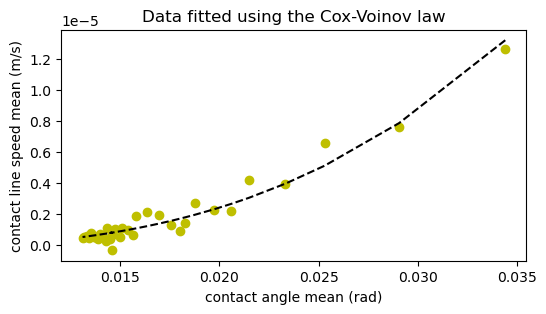

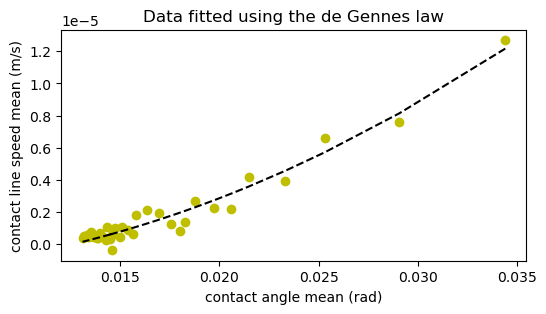

In [10]:
# Plot the data and the fit for the Cox-Voinov law on the same graph
plt.rcParams["figure.figsize"] = (6,3)
plt.figure()
plt.plot(CONTACT_ANGLE_MEAN[1:], CONTACT_LINE_SPEED_MEAN * MICROMETERS_METERS_CONVERSION, 'yo', CONTACT_ANGLE_MEAN[1:],
         FITTED_DATA_3,'--k')
plt.xlabel("contact angle mean (rad)")
plt.ylabel("contact line speed mean (m/s)")
plt.title("Data fitted using the Cox-Voinov law")
plt.show()
# Plot the data and the fit for the de Gennes law law on the same graph
plt.rcParams["figure.figsize"] = (6,3)
plt.figure()
plt.plot(CONTACT_ANGLE_MEAN[1:], CONTACT_LINE_SPEED_MEAN * MICROMETERS_METERS_CONVERSION, 'yo', CONTACT_ANGLE_MEAN[1:],
         FITTED_DATA_2,'--k')
plt.xlabel("contact angle mean (rad)")
plt.ylabel("contact line speed mean (m/s)")
plt.title("Data fitted using the de Gennes law")

plt.show()


![](./img/bee.png)
## Chi-squared Test

To establish which of the two laws better fits the data, we conduct the chi-squared test. The case is further strengthened using the residual plots. 

In [11]:
# find the chi squared and reduced chi squared for the Cox-Voinov law
CHI_SQUARED_3, REDUCED_CHI_SQUARED_3 = chi_squared_calculator(CONTACT_LINE_SPEED_MEAN * MICROMETERS_METERS_CONVERSION, 
                                                          FITTED_DATA_3, CONTACT_LINE_SPEED_STD * MICROMETERS_METERS_CONVERSION)
# find the chi squared and reduced chi squared for the de Gennes law
CHI_SQUARED_2, REDUCED_CHI_SQUARED_2 = chi_squared_calculator(CONTACT_LINE_SPEED_MEAN * MICROMETERS_METERS_CONVERSION, 
                                                          FITTED_DATA_2, CONTACT_LINE_SPEED_STD * MICROMETERS_METERS_CONVERSION)
# print the results for each law
print('Result of the Cox-Voinov law:')
print('')
print(('The chi squared value is: ''{0:.4g}').format(CHI_SQUARED_3))
print(('The reduced chi squared value is: ''{0:.4g}').format(REDUCED_CHI_SQUARED_3))
print('')
print('Results of the de Gennes law:')
print('')
print(('The chi squared value is: ''{0:.4g}').format(CHI_SQUARED_2))
print(('The reduced chi squared value is: ''{0:.4g}').format(REDUCED_CHI_SQUARED_2))

Result of the Cox-Voinov law:

The chi squared value is: 30.17
The reduced chi squared value is: 0.9428

Results of the de Gennes law:

The chi squared value is: 32.65
The reduced chi squared value is: 1.02


![](./img/bee.png)
## Determining The Best Drop Spreading Law 

The results of the chi-squared analysis suggest that the Cox-Voinov law is a slightly better fit for the behaviour of the spreading drop, because it has a chi-squared value is closer to 1. Further analysis is carried out below to measure the residuals for each fit. The residuals allow a more informed suggestion of which spreading law fits the data better.

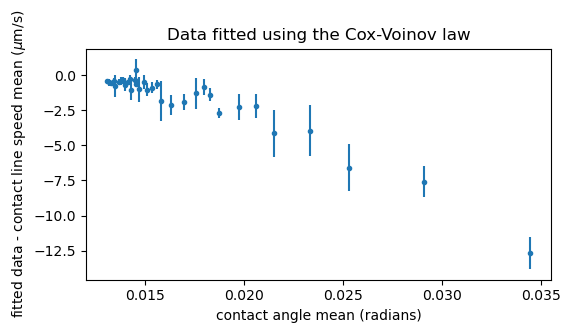

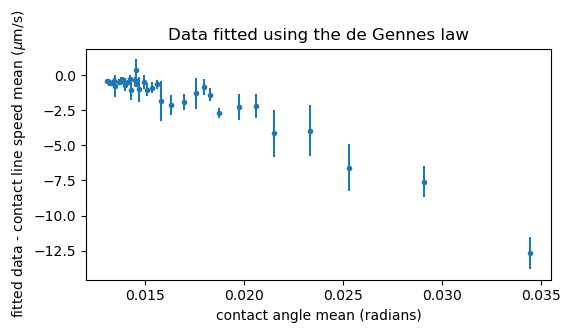

Cox-Voinov law results:

The error due to the experimental data is: 0.649 micrometers/second
The error from fitting is: 0.554 micrometers/second
The difference in errors is: 0.095 micrometers/second
The reduced chi squared value is: 0.943

de Gennes law results:

The error due to the experimental data is: 0.649 micrometers/second
The error from fitting is: 0.538 micrometers/second
The difference in errors is: 0.111 micrometers/second
The reduced chi squared value is: 1.02


In [12]:
# plotting residuals for the Cox-Voinov law 
plt.rcParams["figure.figsize"] = (6,3)
plt.figure()
plt.errorbar(CONTACT_ANGLE_MEAN[1:], FITTED_DATA_3 - CONTACT_LINE_SPEED_MEAN, yerr=CONTACT_LINE_SPEED_STD, fmt='.')
plt.xlabel("contact angle mean (radians)")
plt.ylabel("fitted data - contact line speed mean ($\mu$m/s)")
plt.title("Data fitted using the Cox-Voinov law")
plt.show()

# plotting residuals for the de Gennes law 
plt.rcParams["figure.figsize"] = (6,3)
plt.figure()
plt.errorbar(CONTACT_ANGLE_MEAN[1:], FITTED_DATA_2 - CONTACT_LINE_SPEED_MEAN, yerr=CONTACT_LINE_SPEED_STD, fmt='.')
plt.xlabel("contact angle mean (radians)")
plt.ylabel("fitted data - contact line speed mean ($\mu$m/s)")
plt.title("Data fitted using the de Gennes law")
plt.show()
# print results for the Cox-Voinov law
print('Cox-Voinov law results:')
print('')
print(('The error due to the experimental data is: ''{0:.4g} micrometers/second').
       format(np.mean(CONTACT_LINE_SPEED_STD)))
print(('The error from fitting is: ''{0:.3g} micrometers/second').
       format(FITTED_DATA_3_ERROR / MICROMETERS_METERS_CONVERSION))
print(('The difference in errors is: ''{0:.2g} micrometers/second').
       format(np.mean(CONTACT_LINE_SPEED_STD) - FITTED_DATA_3_ERROR / MICROMETERS_METERS_CONVERSION))
print(('The reduced chi squared value is: ''{0:.3g}').
       format(REDUCED_CHI_SQUARED_3))
print('')
# print results for the de Gennes law
print('de Gennes law results:')
print('')
print(('The error due to the experimental data is: ''{0:.4g} micrometers/second').
       format(np.mean(CONTACT_LINE_SPEED_STD)))
print(('The error from fitting is: ''{0:.3g} micrometers/second').
       format(FITTED_DATA_2_ERROR / MICROMETERS_METERS_CONVERSION))
print(('The difference in errors is: ''{0:.3g} micrometers/second').
       format(np.mean(CONTACT_LINE_SPEED_STD) - FITTED_DATA_2_ERROR / MICROMETERS_METERS_CONVERSION))
print(('The reduced chi squared value is: ''{0:.4g}').
       format(REDUCED_CHI_SQUARED_2))

The difference between the experimental data error and the error from fitting for each spreading law gives an indication of which law best fits the data. This difference in error was smaller for the Cox-Voinov law than the de Gennes law. The reduced chi squared value was also lower for the Cox-Voinov law. This suggests our assertion, that the Cox-Voinov law fits the data better is correct. 

![](./img/bee.png)
## What does this result imply about the contact angle?

The Cox-Voinov law is typically obseravble at high contact angles, so in our case we can say the contact angles are realtively high.

![](./img/bee.png)
## Finding The Characteristic Speed Using Non-Linear Fits

Previously we fitted the data using a linear fit, i.e y=mc+c. However, a non-linear fit can be used for both the Cox-Voinov and de Gennes law. For the Cox-Voinov law the contact line speed data can be fitted against $U= A_3 + B_3\theta + C_3\theta^2 + U_0\theta^3$. The de Gennes law can be fitted using $U= A_2 + B_2\theta + U_0\theta^2$. Then the value of $U_0$ can be found for each fit.

In [13]:
CHARACTERISTIC_SPEED_2_NON_LINEAR, B_2, A_2 = non_linear_fit(2)
CHARACTERISTIC_SPEED_3_NON_LINEAR, C_3, B_3, A_3 = non_linear_fit(3)
# print results for the Cox-Voinov law
print('Cox-Voinov law results:')
print('')
print(('The characteristic speed from the non-linear fit is: ''{0:.4g} micrometers/second').
       format(CHARACTERISTIC_SPEED_3_NON_LINEAR))
print(('The characteristic speed from the linear fit is: ''{0:.4g} micrometers/second').
       format(CHARACTERISTIC_SPEED_3))
# print results for the de Gennes law
print('')
print('de Gennes law results:')
print('')
print(('The characteristic speed from the non-linear fit is: ''{0:.4g} micrometers/second').
       format(CHARACTERISTIC_SPEED_2_NON_LINEAR))
print(('The characteristic speed from the linear fit is: ''{0:.4g} micrometers/second').
       format(CHARACTERISTIC_SPEED_2))

Cox-Voinov law results:

The characteristic speed from the non-linear fit is: -0.217 micrometers/second
The characteristic speed from the linear fit is: 0.3306 micrometers/second

de Gennes law results:

The characteristic speed from the non-linear fit is: 0.01691 micrometers/second
The characteristic speed from the linear fit is: 0.01185 micrometers/second


It is clear from the above results that the non-linear and linear fits produce different results. Why is this? If we look at the fitted equations from above we expect the constants $C_3$, $B_3$ and $B_2$ to be equal to zero as these terms do not appear in the two spreading laws. Lets see if they actually are zero.

In [14]:
# print results for the Cox-Voinov law
print('Cox-Voinov law results:')
print('')
print(('The constant C_3 is: ''{0:.4g}').
       format(C_3))
print(('The constant B_3 is: ''{0:.4g}').
       format(B_3))
# print results for the de Gennes law
print('')
print('de Gennes law results:')
print('')
print(('The constant B_2 is: ''{0:.4g}').
       format(B_2))

Cox-Voinov law results:

The constant C_3 is: 0.03175
The constant B_3 is: -0.0005445

de Gennes law results:

The constant B_2 is: -0.0002255


The constants $B_2$ and $B_3$ are nearly equal to zero, but $C_3$ clearly is not. Therefore, we should not expect the non-linear and linear fits to agree on a value of $U_0$.